[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar-ramos/robotica-autonoma-python/blob/main/3-Intro-Vision/3-11-Deteccion-HoG-SVM-peatones.ipynb)

# Detección de Peatones usando HoG y SVM

Los pasos que se seguirá son los siguientes:
1. Crear un dataset usando atributos HoG de un conjunto de imágenes con peatones (clase positiva) y de un conjunto de imágenes donde no hay peatones (clase negativa)
3. Entrenar un SVM usando los atributos HoG
4. Aplicar SVM a diferentes "patches" (recuadros) de la imagen de prueba para decidir su existe un peatón

In [1]:
import numpy as np
import random
import os

import matplotlib.pyplot as plt
from matplotlib import patches
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

## 1.&nbsp;Creación de datos con atributos HoG

Para los "peatones" se trabajará con el dataset llamado "MIT People dataset", que es libre de ser utilizado para propósitos no comerciales. Este dataset contiene 924 imágenes a color de peatones, cada una de ellas escalada a 64x128 píxeles y alineada de tal modo que el cuerpo de la persona se encuentra en el centro de la imagen.

Para los "no peatones" se puede utilizar imágenes que son similares a peatones pero que no son peatones, como imágenes que contengan autos, bicicletas, calles, casas, bosques, etc.

Asegurarse de tener la carpeta `data2` en el lugar adecuado.

In [6]:
!wget -q https://drive.google.com/uc?id=12ci3EYLJKThyi7GkvxhquGUvGS0HV_lX&export=download
!unzip -qq uc?id=12ci3EYLJKThyi7GkvxhquGUvGS0HV_lX

!wget -q https://github.com/oscar-ramos/robotica-autonoma-python/raw/main/3-Intro-Vision/imagenes/peatones.jpg

Tamaño de la imagen: (128, 64, 3)
Tamaño de la imagen: (128, 64, 3)
Tamaño de la imagen: (128, 64, 3)
Tamaño de la imagen: (128, 64, 3)
Tamaño de la imagen: (128, 64, 3)


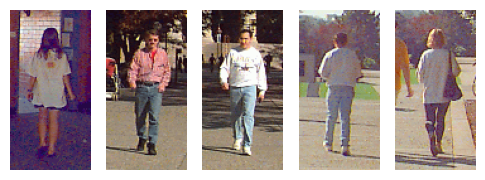

In [9]:
# Ejemplos de peatones
datadir = "pedestrians_pos"

plt.figure(figsize=(6, 4))
for i in range(5):
    filename = "%s/per0010%d.ppm" % (datadir, i)
    img = cv2.imread(filename)
    print("Tamaño de la imagen:", img.shape)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

Tamaño de la imagen: (256, 256, 3)
Tamaño de la imagen: (256, 256, 3)
Tamaño de la imagen: (256, 256, 3)
Tamaño de la imagen: (256, 256, 3)
Tamaño de la imagen: (256, 256, 3)


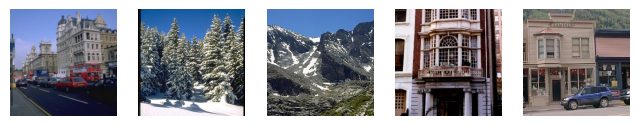

In [11]:
# Ejemplos de no peatones
negdir = "pedestrians_neg"

i = 0
plt.figure(figsize=(8, 4))
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    img = cv2.imread(filename)
    print("Tamaño de la imagen:", img.shape)

    plt.subplot(1, 5, i + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')

    i+=1;
    if (i>4): break

### 1.1. Objeto descriptor HoG

En OpenCV se puede acceder a este descriptor utilizando `cv2.HOGDescriptor`, el cual toma argumentos de entrada como el tamaño de la ventana de detección `win_size` (menor tamaño del objeto a ser detectado), el tamaño de bloque `block_size` (cuán grande es cada bloque: 16 x 16), el tamaño de cada celda (8 x 8), y el paso de celda `cell_stride` (cuántos píxeles moverse para pasar de una celda a la siguiente). Para cada celda, el descriptor HoG calcula un histograma de gradientes orientados usando 9 intervalos ("bins")

In [12]:
win_size = (48, 96)
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
num_bins = 9

hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

### 1.2. HoG para peatones (clase positiva)

Se construirá un dataset `Xpos` que contiene los atributos HoG para una cantidad de imágenes positivas (800 imágenes seleccionadas aleatoriamente de las 900 que existen)

In [16]:
random.seed(42)
Nimg_pos = 800
X_pos = []

for i in random.sample(range(1,900), Nimg_pos):
    filename = "%s/per%05d.ppm" % (datadir, i)
    img = cv2.imread(filename)
    if img is None:
        print('No se pudo encontrar la imagen %s' % filename)
        continue
    # Extraer HoG y añadirlo a X_pos
    X_pos.append(hog.compute(img, (64, 64)))

# Vector de atributos positivos (se fuerza a que los elementos sean de 32 bits)
X_pos = np.array(X_pos, dtype=np.float32)
# Vector de etiquetas positivas: se utilizará "+1"
y_pos = np.ones(X_pos.shape[0], dtype=np.int32)

print("Tamaño de atributos positivos:", X_pos.shape)    # 400 elementos, cada uno de tamaño 1980 (dimensión de HoG)
print("Tamaño de vector de etiquetas positivas:", y_pos.shape)

Tamaño de atributos positivos: (800, 1980)
Tamaño de vector de etiquetas positivas: (800,)


### 1.3. HoG para no peatones (clase negativa)

Las imágenes negativas tienen tamaño 256 x 256 píxeles. Para poder ser utilizadas, su tamaño debe ser el mismo que el tamaño de las imágenes positivas. Por este motivo, para cada imagen negativa se tomará 15 regiones de interés (ROI) de dicho tamaño: 64 x 128.

In [18]:
hroi = 128
wroi = 64

X_neg = []
for negfile in os.listdir(negdir):
    filename = '%s/%s' % (negdir, negfile)
    # Leer la imagen
    img = cv2.imread(filename)
    # Escalar la imagen
    img = cv2.resize(img, (512, 512))
    # Para cada imagen, obtener 5 ROIs de 64x128 localizados aleatoriamente
    for j in range(15):
        rand_y = random.randint(0, img.shape[0] - hroi)
        rand_x = random.randint(0, img.shape[1] - wroi)
        roi = img[rand_y:rand_y + hroi, rand_x:rand_x + wroi, :]
        # Extraer HoG y añadirlo a Xneg
        X_neg.append(hog.compute(roi, (64, 64)))

# Vector de atributos negativos (se fuerza a que los elementos sean de 32 bits)
X_neg = np.array(X_neg, dtype=np.float32)
# X_neg = X_neg[:,:,-1]
# Vector de etiquetas negativas: se utilizará "-1"
y_neg = -np.ones(X_neg.shape[0], dtype=np.int32)

print("Tamaño de atributos negativos:", X_neg.shape)    # 250 elementos, cada uno de tamaño 1980 (dimensión de HoG)
print("Tamaño de vector de etiquetas negativas:", y_neg.shape)

Tamaño de atributos negativos: (750, 1980)
Tamaño de vector de etiquetas negativas: (750,)


### 1.4. Dataset con atributos HoG de elementos positivos y negativos

Se concatenará todas las instancias positivas (`X_pos`) con las instancias negativas (`X_neg`) en un solo dataset `X`, a partir del cual se obtendrá un conjunto de entrenamiento y uno de pruebta usando la función `train_test_split` de scikitlearn.

In [19]:
X = np.concatenate((X_pos, X_neg))
y = np.concatenate((y_pos, y_neg))

In [20]:
# Datos de entrenamiento y de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Número de datos de entrenamiento:", X_train.shape[0])
print("Número de datos de prueba:", X_test.shape[0])

Número de datos de entrenamiento: 1240
Número de datos de prueba: 310


## 2.&nbsp;Clasificación usando SVM (Support Vector Machine)

In [22]:
# Creación del SVM con kernel RBF y gamma=0.2
svm = SVC(kernel='rbf', gamma=0.2)

# Entrenamiento
svm.fit(X_train, y_train);

In [23]:
# Exactitud en el conjunto de entrenamiento
ytrain_pred = svm.predict(X_train)
acc_train = accuracy_score(ytrain_pred, y_train)
print("Exactitud en el conjunto de entrenamiento: {} %".format(100*acc_train))

# Exactitud en el conjunto de prueba
ytest_pred = svm.predict(X_test)
acc_test = accuracy_score(ytest_pred, y_test)
print("Exactitud en el conjunto de prueba: {} %".format(np.round(100*acc_test, 2)))

Exactitud en el conjunto de entrenamiento: 100.0 %
Exactitud en el conjunto de prueba: 98.06 %


## 3.&nbsp;Prueba de la detección con una imagen

Se realizará un bucle sobre distintos patches (bloques) de una imagen de prueba. En cada iteración, se desplazará la región de interés usando una cierta cantidad de píxeles ("stride").

In [25]:
img_test = cv2.imread('peatones.jpg')
stride = 10

# Tamaño de las regiones de interés
hroi = 128
wroi = 64

# Puntos de inicio para cada sub-ventana (en x, y)
ystart_pts = np.arange(0, img_test.shape[0], stride)
xstart_pts = np.arange(0, img_test.shape[1], stride)

found = []
# Recorrido de la imagen usando bloques de ROIs (regiones de interés)
flag = False
for ystart in ystart_pts:
    for xstart in xstart_pts:

        # Si el bloque sale de la imagen, continuar la siguiente iteración
        if ystart + hroi > img_test.shape[0]:
            continue
        if xstart + wroi > img_test.shape[1]:
            continue

        # Región de interés (ventana)
        roi = img_test[ystart:ystart+hroi, xstart:xstart+wroi, :]
        # Atributos HoG de la región de interés
        feat = np.array([hog.compute(roi, (64, 64))])
        # Predicción para los atributos HoG de la región de interés
        ypred = svm.predict(feat)           # Predicción
        yconf = svm.decision_function(feat)    # Seguridad de la predicción ("confidence")

        # Si se detecta un objeto, se almacena la detección y sus "límites" (que definen el "bounding box")
        if np.allclose(ypred, 1):
            # print(ypred, yconf)
            # Si se tiene alta seguridad de la predicción se añade
            if (yconf > 0.1):
                found.append((ystart, xstart, hroi, wroi))

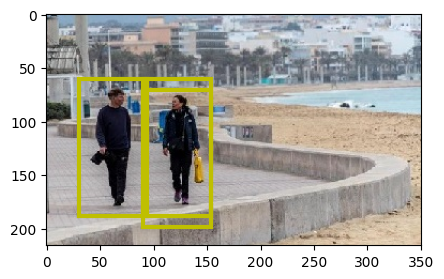

In [27]:
fig = plt.figure(figsize=(6, 3))

# Mostrar la imagen
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
# Dibujar los rectángulos detectados
for f in found:
    ax.add_patch(patches.Rectangle((f[1], f[0]), f[3], f[2], color='y', linewidth=3, fill=False))

Dado que los peatones son de tamaño similar al del conjunto de entrenamiento, son detectados. Para detectar peatones a diferentes escalas sería necesario realizar un escalamiento de la imagen o un escalamiento del cuadro.